## Introduction

In [1]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def render_inequalities(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), np.array(feasible_point))
    fig = plt.figure()
    ax = fig.add_subplot('111', aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 100)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")

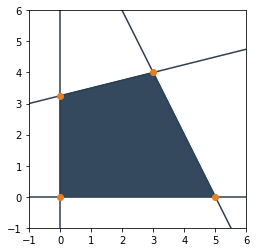

In [2]:
halfspaces = [
    [-1, 0., 0.],    # x₁ ≥ 0
    [0., -1., 0.],   # x₂ ≥ 0
    [-1., 4., -13.], # 4x₂ - x₁ ≤ 13
    [2., 1., -10.]   # x₂ + 2x₁ ≤ 10
]
feasible_point = [0.5, 0.5]
xlim = (-1, 6)
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

## Preparation for Simplex Method

In [3]:
a = [
    [-1, 4, 1, 0],
    [2, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]
b = [13, 10, 0, 0]
x1, x2, x3, x4 = np.linalg.solve(a, b)
print('x1 =', x1)
print('x2 =', x2)

x1 = 3.0
x2 = 4.0


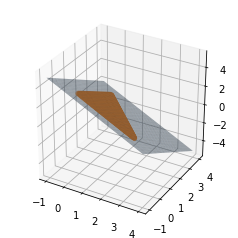

In [4]:
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection='3d', aspect='equal')

# plane: a*x1 + b*x2 + c*x3 + d = 0
normal = [1, 1, 1]
point = [1, 1, 1]
d = -3

xx, yy = np.meshgrid(np.linspace(-1, 4, 100), np.linspace(-1, 4, 100))
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
plt3d.plot_surface(
    xx,
    yy,
    zz,
    alpha=0.5,
    color="#34495e"
)

ax = plt.gca()
for row_i, row in enumerate(xx):
    x_row = []
    y_row = []
    z_row = []
    for column_i, x in enumerate(row):
        y = yy[row_i][column_i]
        z = zz[row_i][column_i]
        if x < 0 or y < 0 or z < 0:
            continue

        x_row.append(x)
        y_row.append(y)
        z_row.append(z)
    if len(x_row) > 0:
        ax.scatter(
            x_row,
            y_row,
            z_row,
            color="#e67e22"
        )

plt.show()

## Simplex Method

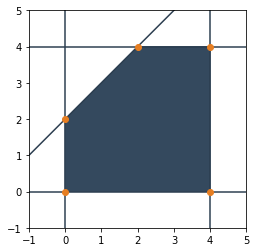

In [5]:
halfspaces = [
    [-1, 0, 0],    # x₁ ≥ 0
    [0, -1, 0],    # x₂ ≥ 0
    [-1, 1, -2],   # -x₁ + x₂ ≤ 2
    [1, 0, -4],    # x₁ ≤ 4
    [0, 1, -4],    # x₂ ≤ 4
]
feasible_point = np.array([0.5, 0.5])
xlim = (-1, 5)
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

In [6]:
c = [1, 1, 0, 0, 0]
A = [
    [-1, 1, 1, 0, 0],
    [ 1, 0, 0, 1, 0],
    [ 0, 1, 0, 0, 1]
]
b = [2, 4, 4]

In [7]:
def to_tableau(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]

In [8]:
def can_be_improved(tableau):
    z = tableau[-1]
    return any(x > 0 for x in z[:-1])

In [9]:
import math

def get_pivot_position(tableau):
    z = tableau[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)

    row = restrictions.index(min(restrictions))
    return row, column

In [10]:
def pivot_step(tableau, pivot_position):
    new_tableau = [[] for eq in tableau]
    
    i, j = pivot_position
    pivot_value = tableau[i][j]
    new_tableau[i] = np.array(tableau[i]) / pivot_value
    
    for eq_i, eq in enumerate(tableau):
        if eq_i != i:
            multiplier = np.array(new_tableau[i]) * tableau[eq_i][j]
            new_tableau[eq_i] = np.array(tableau[eq_i]) - multiplier
   
    return new_tableau

In [11]:
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(tableau):
    columns = np.array(tableau).T
    solutions = []
    for column in columns:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)
        
    return solutions

In [12]:
def simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)

In [13]:
solution = simplex(c, A, b)
print('solution: ', solution)

solution:  [4.0, 4.0, 2.0, 0, 0, 0]


In [65]:
def simplex_with_visualization(c, A, b, halfspaces, feasible_point):
    tableau = to_tableau(c, A, b)

    solutions = [get_solution(tableau)]
    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)
        solutions.append(get_solution(tableau))
    
    points = [v[:2] for v in solutions]
    xlim = (-1, max([p[0] for p in points]) + 1)
    ylim = (-1, max([p[1] for p in points]) + 1)
    render_inequalities(halfspaces, feasible_point, xlim, ylim)

    for start, end in zip(points[:-1], points[1:]):
        plt.arrow(
            start[0],
            start[1],
            end[0] - start[0],
            end[1] - start[1],
            width=0.1,
            length_includes_head=True,
            color='#1abc9c'
        )
    return get_solution(tableau)

[4.0, 4.0, 2.0, 0, 0, 0]

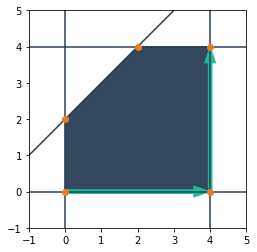

In [66]:
simplex_with_visualization(c, A, b, halfspaces, feasible_point)